# Autophase and Autophase and Scale examples

This includes general (slow) autophasing and scaling, as well as fast autophasing.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from impact import Impact

import numpy as np

# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

NUMPROCS = 8

Make Impact object from the LCLS injector model:

In [3]:
ifile ='templates/lcls_injector/ImpactT.in'

In [4]:
I = Impact(ifile, verbose=True)
I.numprocs=1

Configured to run in: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpfs9aorq4
Setting Npcol, Nprow = 1, 1


# Phase and Scale the LCLS gun

In [5]:
from impact.autophase import autophase_and_scale

from pmd_beamphysics import single_particle

P0 = single_particle(pz=1e-15, z=1e-15)

In [6]:
autophase_and_scale(I, phase_ele_name='GUN', target=6e6,
                     phase_range=(270, 360),
                    scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Scaling GUN by changing rf_field_scale
Bounds: 0.0, 0.15 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 270, Scale: 10000000.0, 1.3066482616283404 MeV
Phase: 0, Scale: 10000000.0, 0.889899440680668 MeV
Exception with Phase: 124.37693999999999, Scale: 10000000.0,'final_particles'
Exception with Phase: 214.37694226404, Scale: 10000000.0,'final_particles'
Phase: 304.37694, Scale: 10000000.0, 1.1065852470188486 MeV
Phase: 278.2536823231907, Scale: 10000000.0, 1.2957644153200447 MeV


/Users/chrisonian/Code/GitHub/lume-impact/impact/parsers.py:1997: UserWarning: Empty file: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpwbm_2kmy/fort.50
  warnings.warn(f'Empty file: {filePath}')
/Users/chrisonian/Code/mambaforge/envs/lume-impact-dev/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Phase: 270.30017170510285, Scale: 10000000.0, 1.3066336280987214 MeV
Exception with Phase: 269.72999999999, Scale: 10000000.0,'final_particles'
Step 1 phasing found: 270
Phase: 270, Scale: 10000000.0, 1.3066482616283404 MeV
Phase: 270, Scale: 100000000.0, 10.753457854685582 MeV
Phase: 270, Scale: 54713683.73550004, 6.47888084960828 MeV
Phase: 270, Scale: 50573783.510182634, 6.066701924203923 MeV
Phase: 270, Scale: 49913221.32431346, 6.000425786826622 MeV
Phase: 270, Scale: 49888264.71365131, 5.997918912975785 MeV
Step 2  scale found: 49913221.32431346
Exception with Phase: 269, Scale: 49913221.32431346,'final_particles'
Phase: 271, Scale: 49913221.32431346, 6.001231586796401 MeV
Phase: 274.236068, Scale: 49913221.32431346, 6.0137277403129685 MeV
Phase: 272.62140751668596, Scale: 49913221.32431346, 6.005739244654294 MeV
Phase: 279.472136050312, Scale: 49913221.32431346, 6.057790211736788 MeV
Phase: 287.9442721820305, Scale: 49913221.32431346, 6.156595248444007 MeV
Phase: 301.65247649577

(304.8351087266176, 47541388.545513116)

Check the energy:

In [7]:
I.verbose=False
PF = I.track(P0, s=0.15)
PF['mean_energy']

6000000.052316555

Examine this process using the debug flag. This will return the function used for phasing and scaling. 

In [8]:
ps_f, Itest = autophase_and_scale(I, phase_ele_name='GUN', target=6e6, initial_particles=P0, verbose=False,
                     debug = True)


Plot various phases and scales:

/Users/chrisonian/Code/GitHub/lume-impact/impact/parsers.py:1997: UserWarning: Empty file: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpd6liy9er/fort.50
  warnings.warn(f'Empty file: {filePath}')


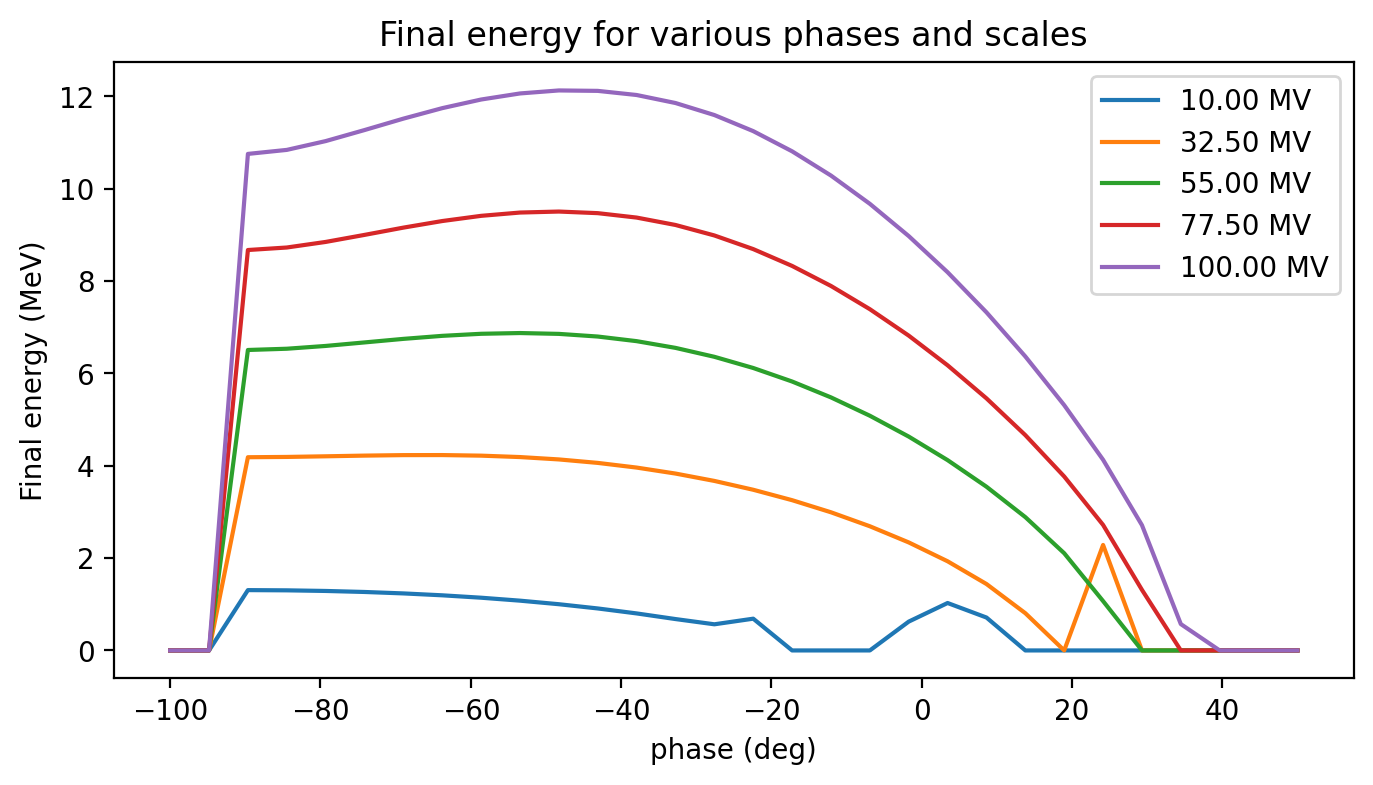

In [9]:
ptry = np.linspace(-100, 50, 30)
for sc in np.linspace(10e6, 100e6, 5):
    res = np.array([ps_f(p, sc)/1e6 for p in ptry])
    plt.plot(ptry, res, label=f'{sc/1e6:0.2f} MV')
plt.title('Final energy for various phases and scales')
plt.ylabel('Final energy (MeV)')
plt.xlabel('phase (deg)')
plt.legend()

Make a 3D data and plot the surface

In [10]:
X = np.linspace(-100, 50, 10)
Y = np.linspace(10e6, 100e6, 10)
X, Y = np.meshgrid(X, Y)
@np.vectorize
def f(phase, scale):
    return ps_f(phase, scale)
Z = f(X, Y)

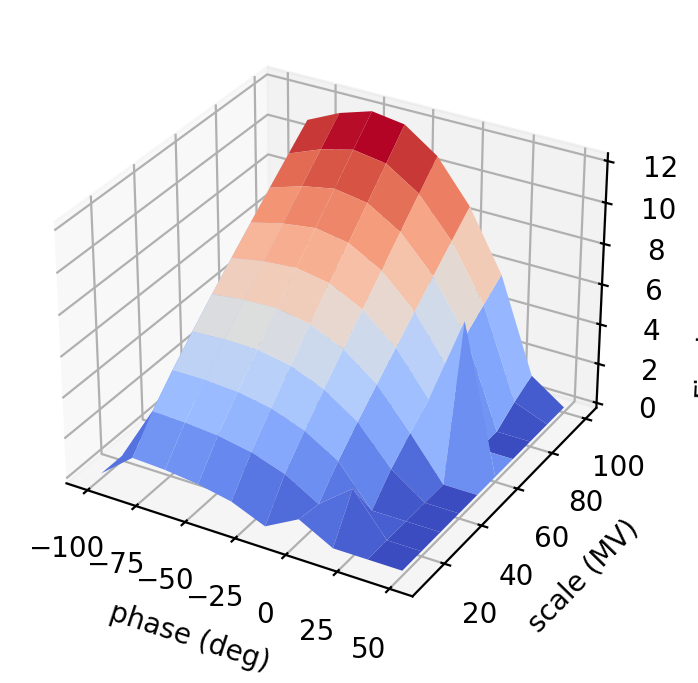

In [11]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y/1e6, Z/1e6, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=True)

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('phase (deg)')
ax.set_ylabel('scale (MV)')
ax.set_zlabel('Final energy (MeV)')
plt.show()



# Phase and scale LCLS linac sections 

Linacs L0A and L0B are special, because they require 4 fieldmaps each to model the travelling wave structure. To tune these together, we need to add control groups. 

These will control overall phases:

In [12]:
I.add_group('L0A', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'], var_name='theta0_deg', attributes='theta0_deg')
I.add_group('L0B', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'], var_name='theta0_deg', attributes='theta0_deg')

ControlGroup(**{"ele_names": ["L0B_entrance", "L0B_body_1", "L0B_body_2", "L0B_exit"], "var_name": "theta0_deg", "attributes": ["theta0_deg", "theta0_deg", "theta0_deg", "theta0_deg"], "factors": [1.0, 1.0, 1.0, 1.0], "reference_values": [42.27, 72.27, 132.27, 42.27], "absolute": false, "value": 0.0, "name": "L0B"})

These will control overall scaling, respecting the special factors:

In [13]:
I.add_group('L0A_scale', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I.add_group('L0B_scale', ele_names=['L0B_entrance', 'L0B_body_1', 'L0B_body_2', 'L0B_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I['L0A_scale']['rf_field_scale'] = 30e6
#I['L0A_scale'].__dict__



Now phase and scale L0A to 64 MeV:

In [14]:
res_L0A = autophase_and_scale(I, phase_ele_name='L0A', scale_ele_name='L0A_scale', target=64e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0A by changing theta0_deg
Scaling L0A_scale by changing rf_field_scale
Bounds: 1.485, 4.527856 m
Tracking initial particles to s = 1.485
Initial particle:  1.48542826464 6000000.052316555
Disabling GUN
Disabling SOL1
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 14.167255568451399 MeV
Phase: 180, Scale: 10000000.0, 14.167255568451399 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 19.900599221695774 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 8.713842837178289 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 19.90060061459368 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 8.713840068114541 MeV
Phase: 222.492259613844, Scale: 10000000.0, 10.405713584184868 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 8.198791876959703 MeV
Phase: 333.73836403267615, Scale: 10000000.0, 23.419924482386943 MeV
Phase: 291.2461345122325, Scale: 10000000.0, 14.43130

Do the same for L0B:

In [15]:
autophase_and_scale(I, phase_ele_name='L0B', scale_ele_name='L0B_scale', target=135e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0B by changing theta0_deg
Scaling L0B_scale by changing rf_field_scale
Bounds: 5.328756, 8.371612 m
Tracking initial particles to s = 5.328756
Initial particle:  5.32879920224 63999921.09254425
Disabling GUN
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 44.70994104184851 MeV
Phase: 180, Scale: 10000000.0, 44.70994104184851 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 78.71763465275679 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 61.59522101051607 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 78.71763587301102 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 61.595214959403094 MeV
Phase: 222.4922500294541, Scale: 10000000.0, 49.294788977865146 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 52.83159870312501 MeV
Phase: 333.7383603717651, Scale: 10000000.0, 80.97585983215453 MeV
Phase: 291.2461285887539, Scale: 10000000.0, 70.31

(2.2134134937279346, 36780531.58486758)

Check the final energy and plot:

In [16]:
I.track(P0, s=8.371612)['mean_energy']

134999248.954592

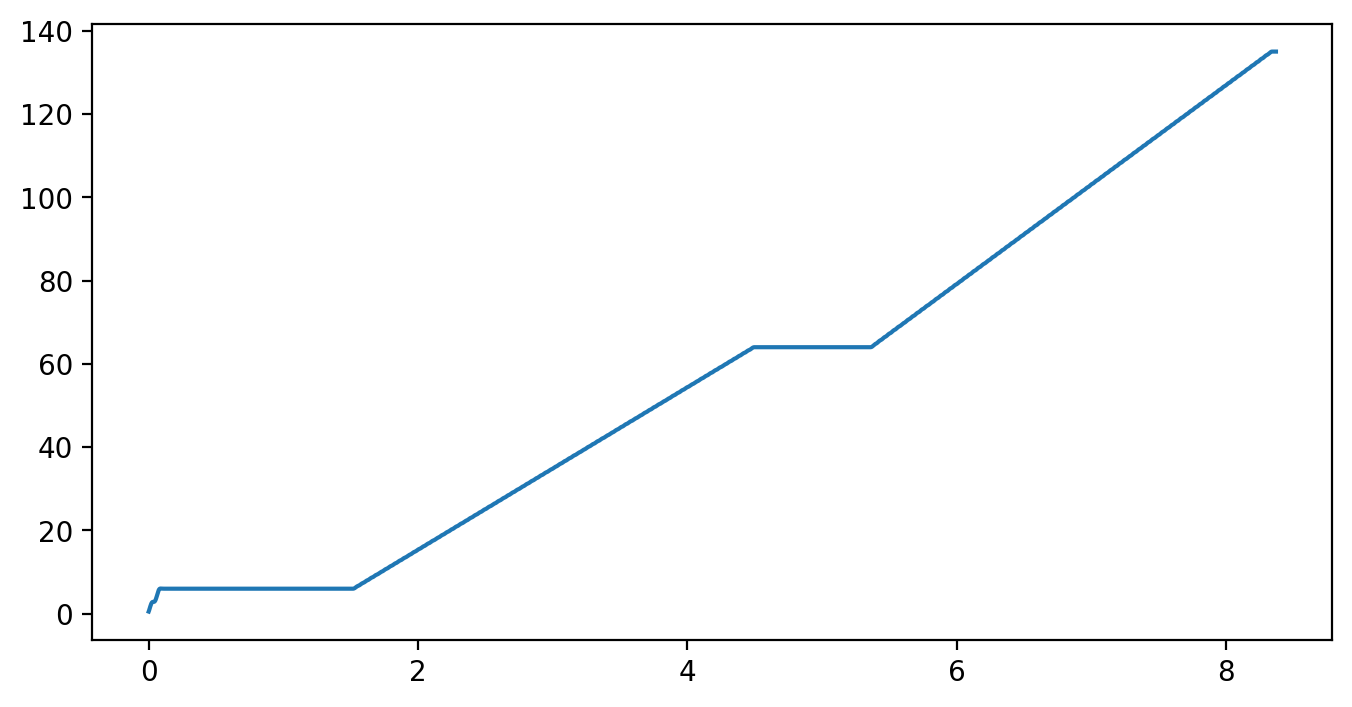

In [17]:
plt.plot(I.stat('mean_z'), I.stat('mean_kinetic_energy')/1e6 + 0.511)

# Fast autophase

This is a faster method that can find and set all relative phases by tracking the fields externally.

In [18]:
%%time
I.autophase()

CPU times: user 2.73 s, sys: 4.76 ms, total: 2.74 s
Wall time: 2.74 s


{'GUN': 0.952227592096051,
 'L0A': 0.0126678830614253,
 'L0B': 0.009126886461046979}

Sending in a dict will set these phases as it goes:

In [19]:
I.verbose=True

I.autophase({'GUN': 1,
 'L0A': 2,
 'L0B': 3})

Setting GUN relative phase = 1 deg
Found GUN        relative phase = 1.00 deg
Setting L0A relative phase = 2 deg
Found L0A        relative phase = 2.00 deg
Setting L0B relative phase = 3 deg
Found L0B        relative phase = 3.00 deg


{'GUN': 1.0, 'L0A': 2.0, 'L0B': 3.0}

# Autophase without scaling

Just phasing is simpler.

In [20]:
from impact.autophase import autophase

ifile2 = 'templates/apex_gun/ImpactT.in'

I2 = Impact(ifile2, verbose=False)

In [21]:
autophase(I2, ele_name='APEX_GUN', initial_particles=P0, metric='mean_kinetic_energy', verbose=True)

Copied initial Impact object. 
Phasing APEX_GUN by changing theta0_deg
Bounds: 0.0, 0.199 m
Disabling SOL1
Default brent2 algorithm
Phase: 180, 0.7501400260547707 MeV
Phase: 180, 0.7501400260547707 MeV
Exception with Phase: 42.49224000000004, 'final_particles'
Exception with Phase: 42.49223094384001, 'final_particles'
Exception with Phase: 42.49223999999998, 'final_particles'
Phase: 222.49223547192, 0.46487921649929437 MeV
Phase: 151.59398241178104, 0.714711059468071 MeV


/Users/chrisonian/Code/GitHub/lume-impact/impact/parsers.py:1997: UserWarning: Empty file: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmp9apb_fdy/fort.50
  warnings.warn(f'Empty file: {filePath}')


Phase: 171.3511003792883, 0.7585459504017038 MeV
Phase: 171.34908462106745, 0.7585459029872261 MeV
Phase: 171.4523027473299, 0.7585471358806966 MeV
Phase: 171.45289970740637, 0.7585471359181192 MeV
Phase: 171.45272825449666, 0.7585471359181192 MeV
Phase: 171.45255680175842, 0.7585471359087637 MeV
Set Phase: 171.45272825449666


171.45272825449666

In [22]:
phase_f, Itest = autophase(I2, ele_name='APEX_GUN', metric='mean_kinetic_energy', initial_particles=P0, debug = True)

/Users/chrisonian/Code/GitHub/lume-impact/impact/parsers.py:1997: UserWarning: Empty file: /var/folders/2f/l5_mybzs30j4qqvyj98w1_nw0000gn/T/tmpt5_35hzt/fort.50
  warnings.warn(f'Empty file: {filePath}')


Text(0.5, 0, 'phase (deg)')

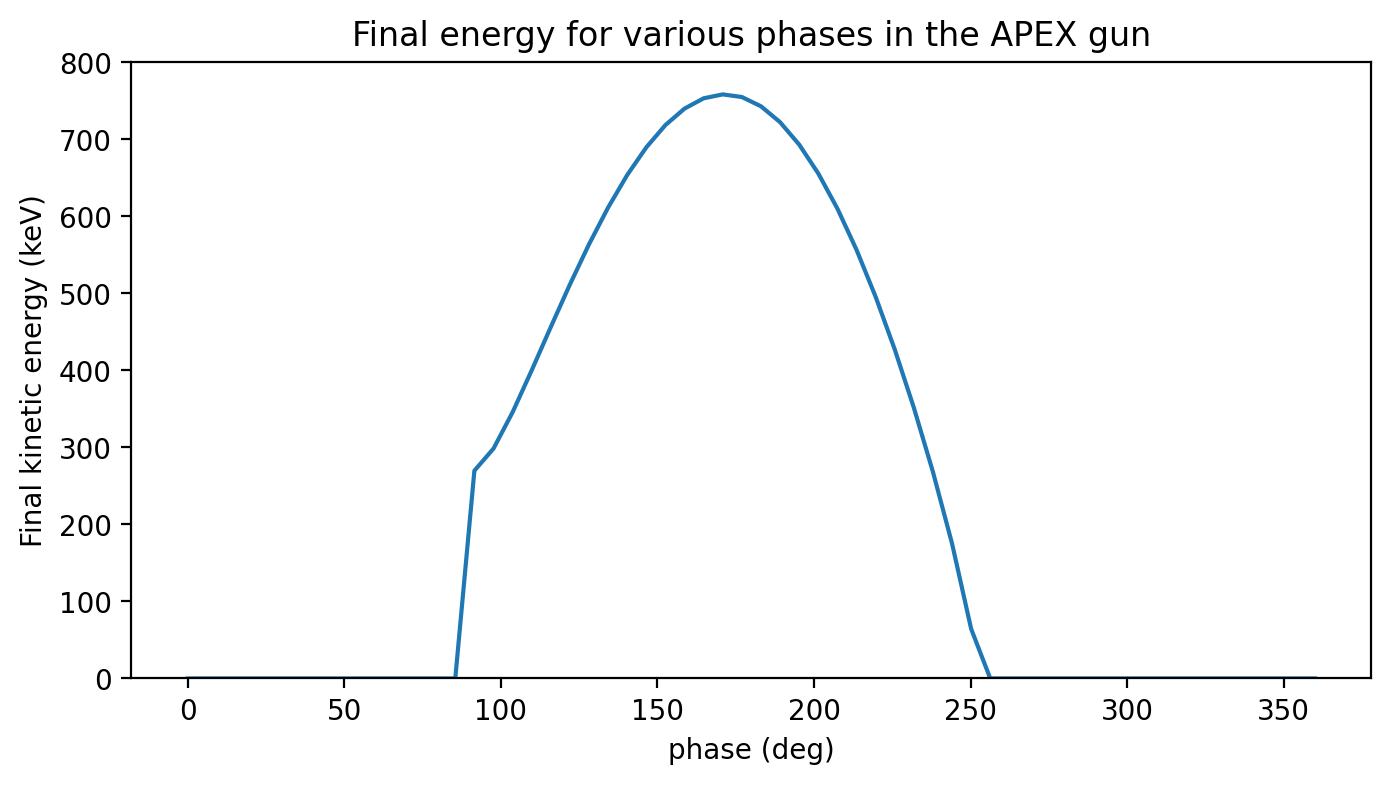

In [23]:
# Phases to try
ptry = np.linspace(0, 360, 60)

energies = np.array([phase_f(p)/1e3 for p in ptry]) 

plt.plot(ptry, energies)
plt.ylim(0, 800)
plt.title('Final energy for various phases in the APEX gun')
plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')


# Autophase with alternative metric, and bunch tracking with space charge.

The above uses `mean_energy` as the metric to maximize. Alternatively, one might want to minimize energy spread. This is accomplished by passing `maximize=False` and  `metric='sigma_pz'` or similar.

In [24]:
from distgen import Generator


ifile = 'templates/lcls_injector/ImpactT.in'
gfile = 'templates/lcls_injector/distgen.yaml'

G = Generator(gfile)
G['n_particle'] = 2000
G.run()
P0 = G.particles


In [25]:
%%time
I = Impact(ifile, initial_particles=P0, verbose=False)
I.stop = 0.16
I.numprocs=NUMPROCS
I.run()

CPU times: user 135 ms, sys: 35.9 ms, total: 171 ms
Wall time: 1min 22s


In [26]:
phase_f, Itest = autophase(I, ele_name='GUN', metric='sigma_pz', maximize=False, initial_particles=P0, debug = True, verbose=True)

Copied initial Impact object. 
Phasing GUN by changing theta0_deg
Bounds: 0.0, 0.15 m
Disabling SOL1
Disabling L0A_entrance
Disabling L0A_body_1
Disabling L0A_body_2
Disabling L0A_exit
Disabling L0B_entrance
Disabling L0B_body_1
Disabling L0B_body_2
Disabling L0B_exit


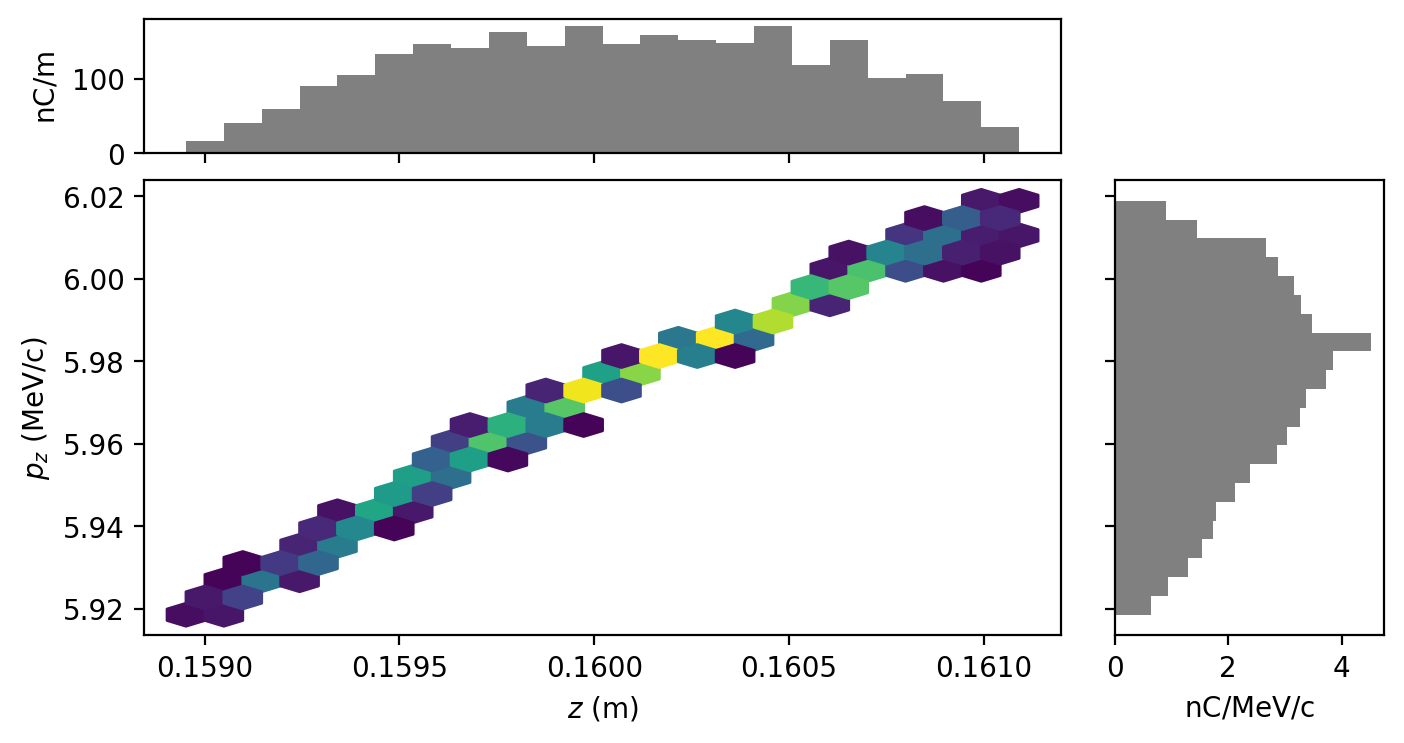

In [27]:
I.particles['final_particles'].plot('z', 'pz')

Phase: 290.0, 0.009085754178422183 MeV/c
Phase: 291.05263157894734, 0.006578656765260174 MeV/c
Phase: 292.10526315789474, 0.004207059004763233 MeV/c
Phase: 293.1578947368421, 0.0022541274747156013 MeV/c
Phase: 294.2105263157895, 0.0021860255994458106 MeV/c
Phase: 295.2631578947368, 0.004043289659012823 MeV/c
Phase: 296.3157894736842, 0.006282846678883406 MeV/c
Phase: 297.36842105263156, 0.00859764434304115 MeV/c
Phase: 298.42105263157896, 0.010935630516750535 MeV/c
Phase: 299.4736842105263, 0.013276394683263821 MeV/c
Phase: 300.5263157894737, 0.015618784622734914 MeV/c
Phase: 301.57894736842104, 0.01796569656136093 MeV/c
Phase: 302.63157894736844, 0.02031237225334309 MeV/c
Phase: 303.6842105263158, 0.02266589802217114 MeV/c
Phase: 304.7368421052632, 0.025021139456963045 MeV/c
Phase: 305.7894736842105, 0.027384699678097663 MeV/c
Phase: 306.8421052631579, 0.029751313075304067 MeV/c
Phase: 307.89473684210526, 0.03212866206883085 MeV/c
Phase: 308.9473684210526, 0.03451123243888133 MeV/c
Ph

Text(0.5, 0, 'phase (deg)')

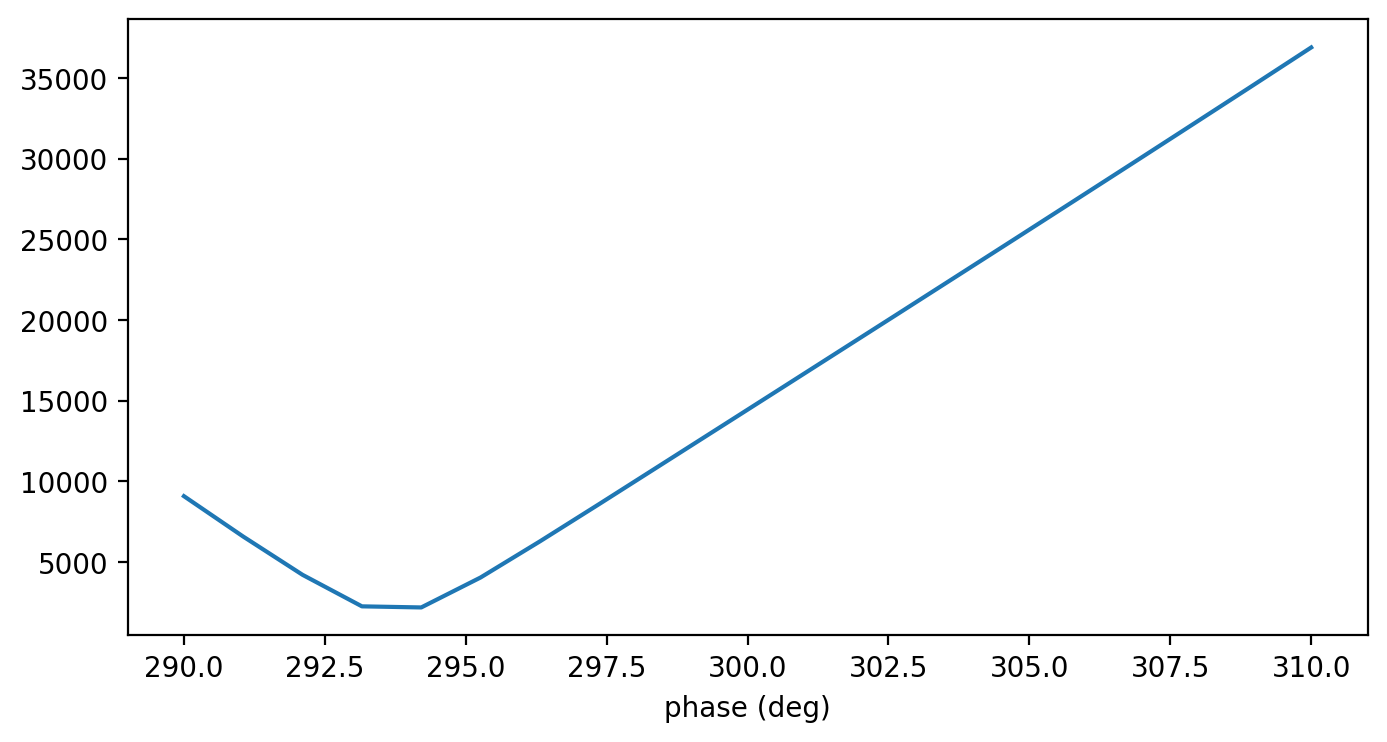

In [28]:
# Phases to try
ptry = np.linspace(290, 310, 20)

sigma_pzs = np.array([phase_f(p) for p in ptry]) 

plt.plot(ptry, sigma_pzs)
#plt.ylim(0, 800)
#plt.title('Final energy for various phases in the APEX gun')
#plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')

In [29]:
phase_f(293.5)

Phase: 293.5, 0.0019129915380495803 MeV/c


1912.9915380495804

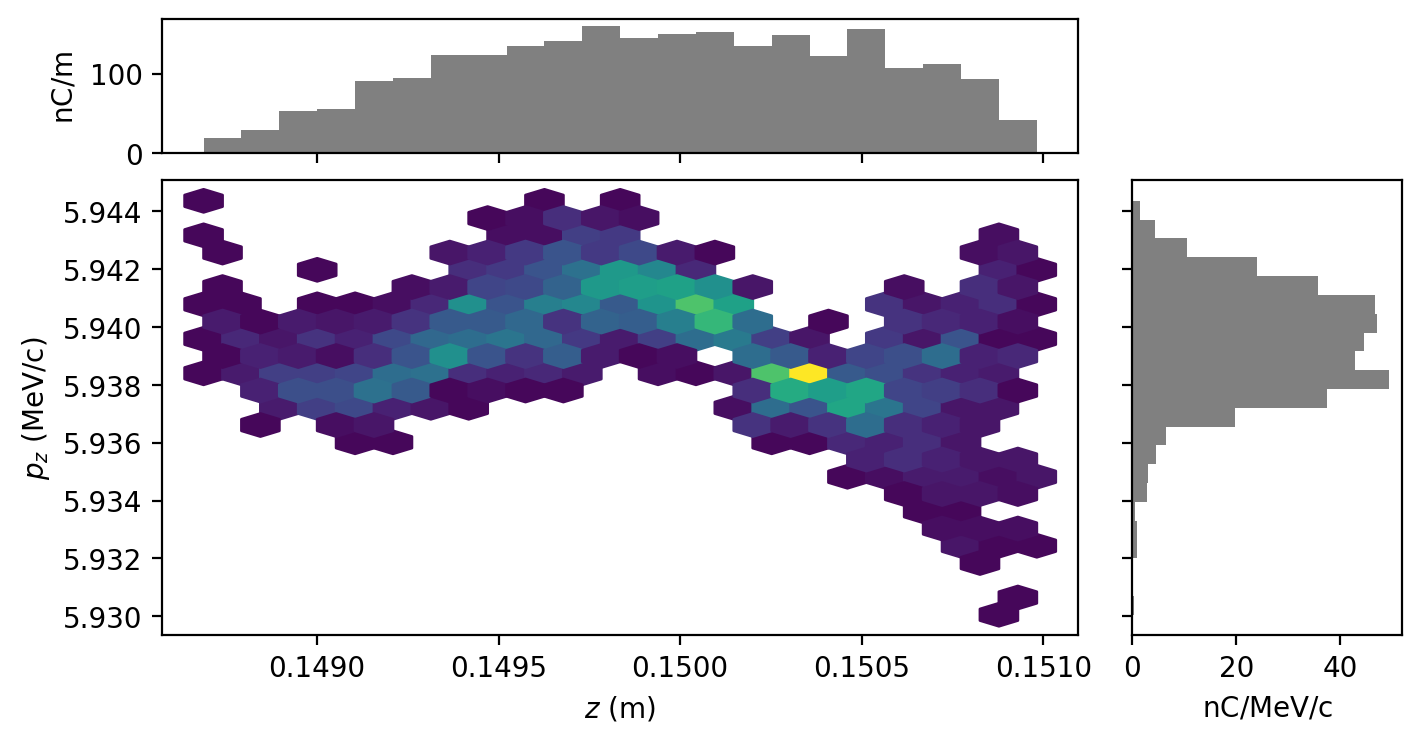

In [30]:
Itest.particles['final_particles'].plot('z', 'pz')

In [ ]:
phase_f, Itest = autophase(I, ele_name='GUN', metric='sigma_pz',
                           maximize=False, initial_particles=P0, debug = True,
                           s_stop = 1.45,
                           verbose=True)
# Phases to try
ptry = np.linspace(270, 290, 30)

sigma_pzs = np.array([phase_f(p) for p in ptry]) 

plt.plot(ptry, sigma_pzs)
#plt.ylim(0, 800)
#plt.title('Final energy for various phases in the APEX gun')
#plt.ylabel('Final kinetic energy (keV)')
plt.xlabel('phase (deg)')

In [32]:
phase_f(280.0)

Phase: 280.0, 0.01898577134704411 MeV/c


18985.771347044112

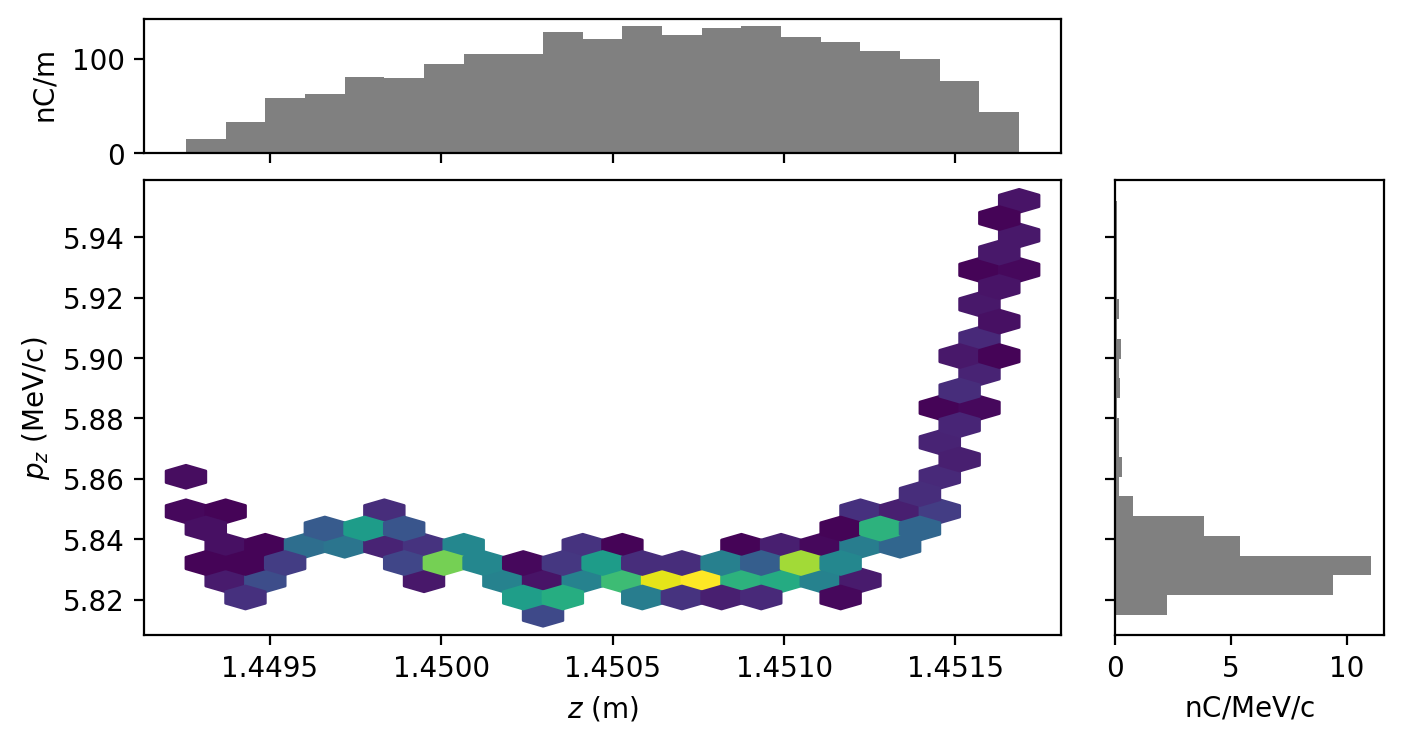

In [33]:
Itest.particles['final_particles'].plot('z', 'pz')